<a href="https://colab.research.google.com/github/Fabri96/The-overstimulated-mice/blob/main/Copia_di_Project_Allen_MAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTANT:
SESSION --> THE TASK, IT CORRESPOND TO ONE MOUSE
EXPERIMENT --> A SINGLE REGISTRATION OF A PLANE FROM ONE SESSION

In [ ]:
# @title Install packages
!pip install pip --upgrade --quiet
#!pip install  pip = 21.3.1
!pip install git+https://github.com/slinderman/AllenSDK@master
!pip install brain_observatory_utilities
!pip install pandas --quiet
!pip install seaborn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.5 MB/s eta 0:00:00
  Cloning https://github.com/slinderman/AllenSDK (to revision master) to /tmp/pip-req-build-pk5sc041
  Running command git clone --filter=blob:none --quiet https://github.com/slinderman/AllenSDK /tmp/pip-req-build-pk5sc041
  Resolved https://github.com/slinderman/AllenSDK to commit 4a507fec0edd06e0909b4fbc69089e4ac12b8c42
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 34.4 MB/s eta 0:00:00
  Obtaining dependency information for hdmf from https://files.pythonhosted.org/packages/01/63/4a03cccd0daf0151026aaf47ec7d1ab41e359d6f708fda3aa216f2b2b9a5/hdmf-3.8.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 11.7 MB/s eta 0:00:00
  Obtaining dependency information for scikit-build from https://files.pythonhosted.org/packages/fa/af/b3ef8fe0bb96bf7308e1

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE

import brain_observatory_utilities.datasets.optical_physiology.data_formatting as ophys_formatting
import brain_observatory_utilities.utilities.general_utilities as utilities

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

# Load the session and experiment summary tables

The AllenSDK provides functionality for downloading tables that describe all sessions and experiments (individual imaging planes) in the Visual Behavior 2P dataset. We first download the data cache:

In [ ]:
data_storage_directory = "/temp"  # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

ophys_session_table.csv: 100%|██████████| 227k/227k [00:00<00:00, 1.36MMB/s] 
behavior_session_table.csv: 100%|██████████| 1.21M/1.21M [00:00<00:00, 6.85MMB/s]
ophys_experiment_table.csv: 100%|██████████| 610k/610k [00:00<00:00, 4.24MMB/s] 
ophys_cells_table.csv: 100%|██████████| 4.29M/4.29M [00:00<00:00, 14.4MMB/s]


- `Ophys_session_table` contains metadata describing imaging sessions. If more than one plane was imaged during a session, one ophys session id will be associated multiple ophys experiment ids. Each ophys session id will also have a unique behavior session id.
- `Behavior_session_table` contains metadata describing behavioral sessions, which may or may not be during imaging. Behavior session ids that do not have ophys session ids were training sessions.
- `Ophys_experiment_table` contains metadata describing imaging experiments (aka imaging planes). When mesoscope is used, one ophys session may contain up to 8 unique experiments (two visual areas by four imaging depths). Some imaging planes may not be released due to quality control issues, thus each ophys session id is associated with anywhere from one to eight unique experiment ids. Ophys experiment ids are unique and do not repeat across sessions. To find the same imaging plane that was matched across multiple sessions, use the `ophys_container_id` column that can be found in both `ophys_session_table` and `ophys_experiment_table`.

Then we can access the session and experiment tables directly.

Note that a 'session' is a single behavioral session. Sessions that are performed on the mesoscope will have multiple (up to 8) 'experiments' associated with them, where an experiment is a distinct imaging plane.

In [ ]:
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()

We can then view the contents of the session table. Note that this contains a lot of useful metadata about each session. One of the columns, `ophys_experiment_id` provides a list of the experiments (aka imaging planes) that are associated with each session.

In [ ]:
session_table.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,behavior_session_id,ophys_experiment_id,ophys_container_id,project_code,date_of_acquisition,session_type
ophys_session_id,,,,,,,,,,,,,,,,,,,
951410079,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0.0,65.0,0.0,951520319,"[951980471, 951980473, 951980475, 951980479, 9...","[1018028360, 1018028345, 1018028357, 101802834...",VisualBehaviorMultiscope,2019-09-20 09:45:29.897856,OPHYS_1_images_A
952430817,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,209.0,Sst-IRES-Cre,GCaMP6f,2.0,0.0,66.0,1.0,952554548,"[953659743, 953659745, 953659749, 953659752]","[1018028357, 1018028345, 1018028339, 1018028354]",VisualBehaviorMultiscope,2019-09-23 08:13:07.627573,OPHYS_2_images_A_passive
954954402,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,210.0,Sst-IRES-Cre,GCaMP6f,3.0,0.0,67.0,2.0,953982960,"[958527464, 958527471, 958527474, 958527479, 9...","[1018028360, 1018028342, 1018028357, 101802835...",VisualBehaviorMultiscope,2019-09-24 16:00:00.000000,OPHYS_3_images_A
955775716,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,212.0,Sst-IRES-Cre,GCaMP6f,3.0,1.0,68.0,3.0,956010809,"[956941841, 956941844, 956941846]","[1018028342, 1018028339, 1018028345]",VisualBehaviorMultiscope,2019-09-26 08:44:37.199778,OPHYS_3_images_A
957020350,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,213.0,Sst-IRES-Cre,GCaMP6f,4.0,0.0,0.0,4.0,957032492,"[957759562, 957759564, 957759566, 957759570, 9...","[1018028354, 1018028345, 1018028360, 101802834...",VisualBehaviorMultiscope,2019-09-27 08:28:05.415005,OPHYS_4_images_B


The experiment table has one row per experiment. Note that the `ophys_session_id` column links each experiment to its associated session in the session_table.

In [ ]:
experiment_table.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,experience_level,passive,image_set,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,,,,
951980486,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0.0,65.0,0.0,951410079,951520319,1018028360,VisualBehaviorMultiscope,300,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,Familiar,False,A,1085400869
951980473,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0.0,65.0,0.0,951410079,951520319,1018028345,VisualBehaviorMultiscope,225,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,Familiar,False,A,1085400919
951980481,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0.0,65.0,0.0,951410079,951520319,1018028357,VisualBehaviorMultiscope,225,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,Familiar,False,A,1085400972
951980471,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0.0,65.0,0.0,951410079,951520319,1018028342,VisualBehaviorMultiscope,150,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,Familiar,False,A,1085394308
951980475,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0.0,65.0,0.0,951410079,951520319,1018028339,VisualBehaviorMultiscope,75,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,Familiar,False,A,1085400920


In [ ]:
experiment_table.loc[:]["targeted_structure"].unique()

array(['VISl', 'VISp', 'VISal', 'VISam'], dtype=object)

TABLE OF SESSIONS

In [ ]:
session_table

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,behavior_session_id,ophys_experiment_id,ophys_container_id,project_code,date_of_acquisition,session_type
ophys_session_id,,,,,,,,,,,,,,,,,,,
951410079,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0.0,65.0,0.0,951520319,"[951980471, 951980473, 951980475, 951980479, 9...","[1018028360, 1018028345, 1018028357, 101802834...",VisualBehaviorMultiscope,2019-09-20 09:45:29.897856,OPHYS_1_images_A
952430817,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,209.0,Sst-IRES-Cre,GCaMP6f,2.0,0.0,66.0,1.0,952554548,"[953659743, 953659745, 953659749, 953659752]","[1018028357, 1018028345, 1018028339, 1018028354]",VisualBehaviorMultiscope,2019-09-23 08:13:07.627573,OPHYS_2_images_A_passive
954954402,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,210.0,Sst-IRES-Cre,GCaMP6f,3.0,0.0,67.0,2.0,953982960,"[958527464, 958527471, 958527474, 958527479, 9...","[1018028360, 1018028342, 1018028357, 101802835...",VisualBehaviorMultiscope,2019-09-24 16:00:00.000000,OPHYS_3_images_A
955775716,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,212.0,Sst-IRES-Cre,GCaMP6f,3.0,1.0,68.0,3.0,956010809,"[956941841, 956941844, 956941846]","[1018028342, 1018028339, 1018028345]",VisualBehaviorMultiscope,2019-09-26 08:44:37.199778,OPHYS_3_images_A
957020350,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,213.0,Sst-IRES-Cre,GCaMP6f,4.0,0.0,0.0,4.0,957032492,"[957759562, 957759564, 957759566, 957759570, 9...","[1018028354, 1018028345, 1018028360, 101802834...",VisualBehaviorMultiscope,2019-09-27 08:28:05.415005,OPHYS_4_images_B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946951902,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,468866,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,152.0,Vip-IRES-Cre,GCaMP6f,3.0,1.0,21.0,7.0,947311015,[947716576],[929913236],VisualBehavior,2019-09-16 16:46:16.000000,OPHYS_3_images_A
948090163,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,468866,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,153.0,Vip-IRES-Cre,GCaMP6f,3.0,2.0,22.0,8.0,948206919,[948507789],[929913236],VisualBehavior,2019-09-17 17:39:10.000000,OPHYS_3_images_A
949209988,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,468866,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,155.0,Vip-IRES-Cre,GCaMP6f,4.0,0.0,0.0,10.0,950157787,[950833329],[929913236],VisualBehavior,2019-09-19 15:34:06.000000,OPHYS_4_images_B


In [ ]:
len(session_table)

705

Let's see the cre lines

In [ ]:
session_table.loc[:]["cre_line"]



ophys_session_id
951410079    Sst-IRES-Cre
952430817    Sst-IRES-Cre
954954402    Sst-IRES-Cre
955775716    Sst-IRES-Cre
957020350    Sst-IRES-Cre
                 ...     
946951902    Vip-IRES-Cre
948090163    Vip-IRES-Cre
949209988    Vip-IRES-Cre
952434025    Vip-IRES-Cre
954958035    Vip-IRES-Cre
Name: cre_line, Length: 705, dtype: object

Let's see the indices of the sessions

```
# Questo è formattato come codice
```



Let's see which are the different unique cre lines

Restrict the session dataframe to the sessions only for one cre line (SST)


---



##Let's have a look at the experiment table

In [ ]:
experiment_table.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,experience_level,passive,image_set,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,,,,
951980486,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0.0,65.0,0.0,951410079,951520319,1018028360,VisualBehaviorMultiscope,300,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,Familiar,False,A,1085400869
951980473,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0.0,65.0,0.0,951410079,951520319,1018028345,VisualBehaviorMultiscope,225,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,Familiar,False,A,1085400919
951980481,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0.0,65.0,0.0,951410079,951520319,1018028357,VisualBehaviorMultiscope,225,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,Familiar,False,A,1085400972
951980471,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0.0,65.0,0.0,951410079,951520319,1018028342,VisualBehaviorMultiscope,150,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,Familiar,False,A,1085394308
951980475,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0.0,65.0,0.0,951410079,951520319,1018028339,VisualBehaviorMultiscope,75,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,Familiar,False,A,1085400920


## Let's see the main areas

In [ ]:
experiment_table.loc[:]["targeted_structure"].unique()

array(['VISl', 'VISp', 'VISal', 'VISam'], dtype=object)

## Let's see the avilable mice with neurons excitatory in V1

In [ ]:
exp_excitatory1 = experiment_table.loc[(experiment_table["cre_line"] == "Slc17a7-IRES2-Cre")  & (experiment_table["targeted_structure"] == 'VISl')]

In [ ]:
exp_excitatory2 = experiment_table.loc[(experiment_table["cre_line"] == "Slc17a7-IRES2-Cre")  & (experiment_table["targeted_structure"] == 'VISp')]

In [ ]:
np.intersect1d(exp_excitatory1[:]["mouse_id"].unique(),exp_excitatory2[:]["mouse_id"].unique())

array(['451787', '453911', '456915', '472271', '477052', '479839',
       '481295', '484408', '484627', '484631', '485152', '513630',
       '541329', '547266', '547486'], dtype=object)

## Function to extract neural data from given mouse, in given area and population

In [ ]:
def extract_neurons(experiment_table,cre_line,area,mouse_id):
#
# Extract from the experiments table the neurons satisfying the given requirements
#
# INPUTS:
#
# experiment_table --> main dataframe contaning experiments
# cre_line --> "Sst-IRES-Cre", "Vip-IRES-Cre" or "Slc17a7-IRES2-Cre"
# area --> targeted_structure plane ('VISl', 'VISp', 'VISal', 'VISam')
#
# OUTPUT
#
# Neurons_activities --> dataframe with dF/F activities of the wanted neurons
#

  # Select from the experiment table the rows satisfying cre_line, visual area and mouse requirements
  my_experiments = experiment_table.loc[(experiment_table["cre_line"] == cre_line) & (experiment_table["targeted_structure"] == area) & (experiment_table["mouse_id"] == mouse_id)  ]

  # Extract their ids
  experiment_ids_list = my_experiments.index;

  # Initialize data structure contaning neural data
  neural_data = []

  # For memory reason, consider only one experiment
  ophys_experiment_id = experiment_ids_list[0]

  # get data for that experiment
  current_experiment = cache.get_behavior_ophys_experiment(ophys_experiment_id)

  this_experiment_neural_data = ophys_formatting.build_tidy_cell_df(current_experiment)

  # add some columns with metadata for the experiment
  metadata_keys = [
    'ophys_experiment_id',
    'ophys_session_id',
    'mouse_id',

  ]

  for metadata_key in metadata_keys:
      this_experiment_neural_data[metadata_key] = current_experiment.metadata[metadata_key]

  # append the data for this experiment to a list
  neural_data.append(this_experiment_neural_data)

  # concatate the list of dataframes into a single dataframe
  neural_data = pd.concat(neural_data)




  return neural_data


## Let's call our function for the excitatory and V1 case, for a random mouse

In [ ]:
# cell with both V1 and LM data
np.intersect1d(exp_excitatory1[:]["mouse_id"].unique(),exp_excitatory2[:]["mouse_id"].unique())

array(['451787', '453911', '456915', '472271', '477052', '479839',
       '481295', '484408', '484627', '484631', '485152', '513630',
       '541329', '547266', '547486'], dtype=object)

In [ ]:
neural_data = extract_neurons(experiment_table,"Slc17a7-IRES2-Cre","VISp",'484627')

behavior_ophys_experiment_971813756.nwb: 100%|██████████| 449M/449M [00:18<00:00, 23.8MMB/s]
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [ ]:
single_cell_timeseries = neural_data.query('cell_specimen_id == 1086602289')
np.std(single_cell_timeseries['dff'])

nan

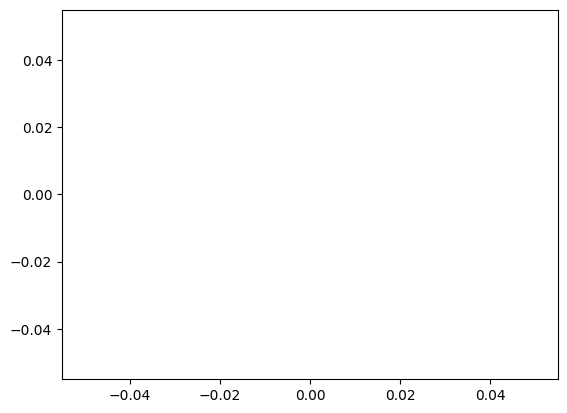

In [ ]:
plt.plot(single_cell_timeseries['dff'])

In [ ]:
neural_data

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,mouse_id
0,8.94066,0.550002,0.0,0.0,1080727392,1086555815,971813756,971632311,484627
1,9.03387,0.355414,0.0,0.0,1080727392,1086555815,971813756,971632311,484627
2,9.12708,0.318926,0.0,0.0,1080727392,1086555815,971813756,971632311,484627
3,9.22029,0.144243,0.0,0.0,1080727392,1086555815,971813756,971632311,484627
4,9.31350,0.301713,0.0,0.0,1080727392,1086555815,971813756,971632311,484627
...,...,...,...,...,...,...,...,...,...
48293,4511.60437,0.223509,0.0,0.0,1080728922,1086542408,971813756,971632311,484627
48294,4511.69761,0.000000,0.0,0.0,1080728922,1086542408,971813756,971632311,484627
48295,4511.79085,0.122800,0.0,0.0,1080728922,1086542408,971813756,971632311,484627
48296,4511.88409,0.330748,0.0,0.0,1080728922,1086542408,971813756,971632311,484627


## Let's save information about the cells in the experiment, the experiment id and create the related experiment object

In [ ]:
my_cell_ids = neural_data['cell_specimen_id'].unique()
curr_exp_id = neural_data['ophys_experiment_id'].unique()
my_experiment = cache.get_behavior_ophys_experiment(curr_exp_id)
stimulus_table = my_experiment.stimulus_presentations #get the stimulus table

/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Allen_project'

In [ ]:
my_cell_ids

[1086555815, 1086546809, 1086510432, 1086510641, 1086510992, ..., 1086541231, 1086541438, 1086541992, 1086542234, 1086542408]
Length: 95
Categories (95, int64): [1086555815, 1086546809, 1086510432, 1086510641, ..., 1086541438, 1086541992,
                         1086542234, 1086542408]

## EXAMPLE OF PERIEVENT PLOT FOR ONE SINGLE CELL

In [ ]:
cell_id = my_cell_ids[0] # consider only one cell


#extract subtable for the familiar case
stimuli_familiar = stimulus_table[stimulus_table['is_change']== False]

stimuli_familiar = stimuli_familiar[stimuli_familiar['omitted']== False]

#extract subtable for the novel case
stimuli_novel = stimulus_table[stimulus_table['is_change']== True]

# build dataframe of centered activities across all familiar stimuli
etr_familiar = utilities.event_triggered_response(
  data=neural_data.query('cell_specimen_id == @cell_id'),
  t='timestamps',
  y='dff',
  event_times = stimuli_familiar['start_time'],
  t_before=0.,
  t_after=0.5,
  output_sampling_rate=10,
)

# build dataframe of centered activities across all novel stimuli
etr_novel = utilities.event_triggered_response(
  data=neural_data.query('cell_specimen_id == @cell_id'),
  t='timestamps',
  y='dff',
  event_times = stimuli_novel['start_time'],
  t_before=0.,
  t_after=0.5,
  output_sampling_rate=10,
)

<Axes: xlabel='time', ylabel='dff'>

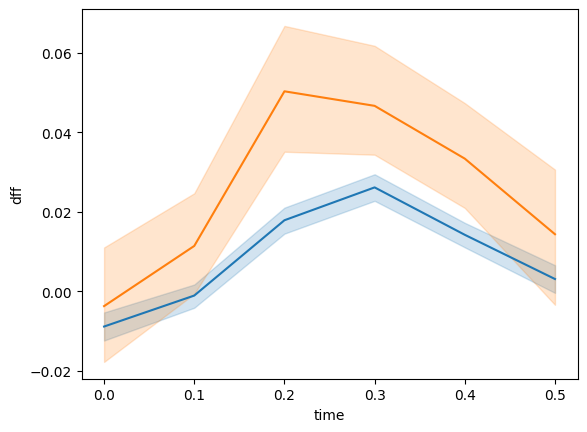

In [ ]:
# Plot the familiar vs novel average responses

sns.lineplot(
    data=etr_familiar,
    x='time',
    y='dff',
    n_boot=500
)

sns.lineplot(
    data=etr_novel,
    x='time',
    y='dff',
    n_boot=500
)

## Now let's do the same for all neurons of the considered experiment: we will create a dataframe for the centered activities concatenating the dataframes of single neurons, one after the other

In [ ]:
# initialize global dataframes for centered activites
etr_familiar_global2 = []

etr_familiar_global = pd.DataFrame(etr_familiar_global2)

etr_novel_global2 = []

etr_novel_global = pd.DataFrame(etr_novel_global2)

#extract subtable for the familiar case
stimuli_familiar = stimulus_table[stimulus_table['is_change']== False]

stimuli_familiar = stimuli_familiar[stimuli_familiar['omitted']== False]

#extract subtable for the novel case
stimuli_novel = stimulus_table[stimulus_table['is_change']== True]


#We loop on every neuron
for cell_id in my_cell_ids:



  etr_familiar = utilities.event_triggered_response(
  data=neural_data.query('cell_specimen_id == @cell_id'),
  t='timestamps',
  y='dff',
  event_times = stimuli_familiar['start_time'],
  t_before=0.,
  t_after=0.5,
  output_sampling_rate=20,
  )

  #concatenate the dataframe for single neuron to the global dataframe for all neurons
  etr_familiar_global = pd.concat([etr_familiar_global, etr_familiar])

  etr_novel = utilities.event_triggered_response(
    data=neural_data.query('cell_specimen_id == @cell_id'),
    t='timestamps',
    y='dff',
    event_times = stimuli_novel['start_time'],
    t_before=0.,
    t_after=0.5,
    output_sampling_rate=20,
  )

  #concatenate the dataframe for single neuron to the global dataframe for all neurons
  etr_novel_global = pd.concat([etr_novel_global, etr_novel])



In [ ]:
etr_novel_global # more than 10 millions of rows! We concatenated all neurons dataframe

,time,dff,event_number,stimulus_presentations_id,event_time
0,0.00,-0.176442,0,16,320.99563
1,0.05,-0.176442,0,16,320.99563
2,0.10,-0.100073,0,16,320.99563
3,0.15,0.070165,0,16,320.99563
4,0.20,0.125873,0,16,320.99563
...,...,...,...,...,...
2646,0.30,-0.066117,240,4773,3892.27956
2647,0.35,-0.101845,240,4773,3892.27956
2648,0.40,-0.110997,240,4773,3892.27956
2649,0.45,-0.113152,240,4773,3892.27956


<Axes: xlabel='time', ylabel='dff'>

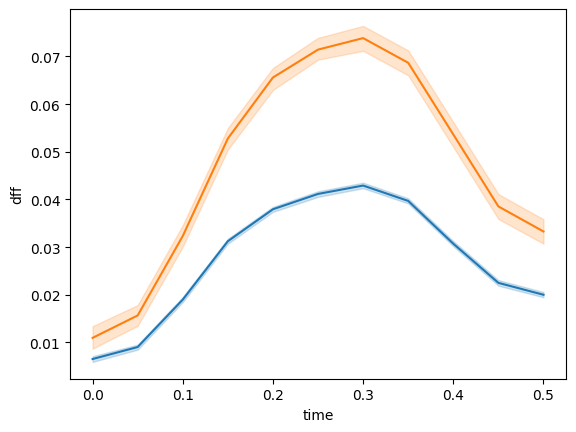

In [ ]:
sns.lineplot(
    data=etr_familiar_global,
    x='time',
    y='dff',
    n_boot=500
)

sns.lineplot(
    data=etr_novel_global,
    x='time',
    y='dff',
    n_boot=500
)


In [ ]:
len(etr_familiar_global[etr_familiar_global['time']==-0.5])

0

In [ ]:
times = etr_familiar_global['time']


In [ ]:
reshaped_times = np.reshape(list(times),(len(etr_familiar_global[etr_familiar_global['time']==0.4]),-1))

In [ ]:
reshaped_times

array([[0.  , 0.05, 0.1 , ..., 0.4 , 0.45, 0.5 ],
       [0.  , 0.05, 0.1 , ..., 0.4 , 0.45, 0.5 ],
       [0.  , 0.05, 0.1 , ..., 0.4 , 0.45, 0.5 ],
       ...,
       [0.  , 0.05, 0.1 , ..., 0.4 , 0.45, 0.5 ],
       [0.  , 0.05, 0.1 , ..., 0.4 , 0.45, 0.5 ],
       [0.  , 0.05, 0.1 , ..., 0.4 , 0.45, 0.5 ]])

In [ ]:
reshaped_dff_familiar = np.reshape(list(etr_familiar_global['dff']),(len(etr_familiar_global[etr_familiar_global['time']==0.4]),-1))
reshaped_dff_familiar

array([[-0.15253212, -0.15253212, -0.09486192, ...,  0.09565995,
         0.10363473,  0.10363473],
       [ 0.37106425,  0.37106425,  0.35190382, ...,  0.05415389,
         0.02344438,  0.02344438],
       [ 0.16747142,  0.16747142,  0.05540477, ..., -0.14025126,
        -0.15690388, -0.15690388],
       ...,
       [-0.05089702, -0.02707019,  0.01819354, ..., -0.06407444,
         0.07870416,  0.19255581],
       [-0.08752495, -0.06964442, -0.04083273, ...,  0.08629929,
         0.0691215 ,  0.05704208],
       [ 0.03117228,  0.05315873,  0.08390042, ...,  0.19243785,
        -0.03745254, -0.17731786]])

In [ ]:
reshaped_dff_novel = np.reshape(list(etr_novel_global['dff']),(len(etr_novel_global[etr_novel_global['time']==0.4]),-1))
reshaped_dff_novel

array([[-0.17644176, -0.17644176, -0.10007309, ..., -0.02615242,
        -0.14223844, -0.1433993 ],
       [-0.08117771, -0.10240648, -0.13357941, ...,  0.01734497,
         0.09533497,  0.14543574],
       [ 0.05738691,  0.06230317,  0.08432945, ...,  0.02266819,
         0.00370807,  0.00370807],
       ...,
       [ 0.02871465, -0.03916672, -0.12478903, ..., -0.05325126,
        -0.12612899, -0.16482706],
       [-0.09429845, -0.09429845, -0.06407329, ..., -0.04277775,
        -0.13051765, -0.13051765],
       [-0.02917264,  0.00076524,  0.13465558, ..., -0.11099726,
        -0.11315166, -0.11315166]])

In [ ]:
reshaped_dff_familiar.mean(axis=0)

array([0.00653047, 0.00904711, 0.0189972 , 0.03124489, 0.03794925,
       0.04116253, 0.04292375, 0.03969705, 0.0307254 , 0.02250921,
       0.02001375])

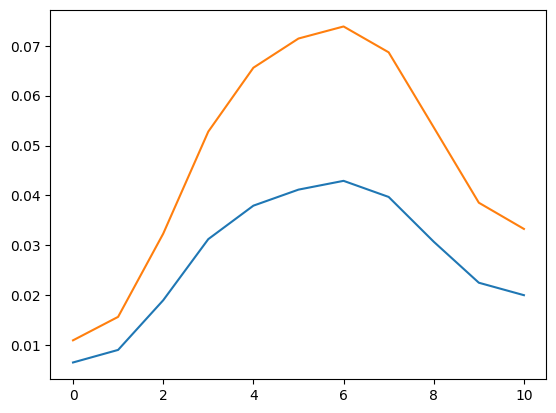

In [ ]:
plt.plot(reshaped_dff_familiar.mean(axis=0))

plt.plot(reshaped_dff_novel.mean(axis=0))

In [ ]:
np.intersect1d(exp_excitatory1[:]["mouse_id"].unique(),exp_excitatory2[:]["mouse_id"].unique())

array(['451787', '453911', '456915', '472271', '477052', '479839',
       '481295', '484408', '484627', '484631', '485152', '513630',
       '541329', '547266', '547486'], dtype=object)

In [ ]:
neural_data_LM = extract_neurons(experiment_table,"Slc17a7-IRES2-Cre",'VISl','484627')

behavior_ophys_experiment_971813767.nwb: 100%|██████████| 442M/442M [00:16<00:00, 27.4MMB/s]
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [ ]:
neural_data_LM

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,mouse_id
0,9.01057,0.082558,0.0,0.0,1080727057,1086514872,971813767,971632311,484627
1,9.10378,0.221052,0.0,0.0,1080727057,1086514872,971813767,971632311,484627
2,9.19699,0.312621,0.0,0.0,1080727057,1086514872,971813767,971632311,484627
3,9.29020,0.394590,0.0,0.0,1080727057,1086514872,971813767,971632311,484627
4,9.38341,0.207002,0.0,0.0,1080727057,1086514872,971813767,971632311,484627
...,...,...,...,...,...,...,...,...,...
48293,4511.67430,0.008264,0.0,0.0,1080728282,1086545183,971813767,971632311,484627
48294,4511.76754,0.233726,0.0,0.0,1080728282,1086545183,971813767,971632311,484627
48295,4511.86078,0.064120,0.0,0.0,1080728282,1086545183,971813767,971632311,484627
48296,4511.95402,0.226663,0.0,0.0,1080728282,1086545183,971813767,971632311,484627


In [ ]:
my_cell_ids_LM = neural_data_LM['cell_specimen_id'].unique()
curr_exp_id_LM = neural_data_LM['ophys_experiment_id'].unique()
my_experiment_LM = cache.get_behavior_ophys_experiment(curr_exp_id)
stimulus_table_LM = my_experiment_LM.stimulus_presentations #get the stimulus table


/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [ ]:
my_cell_ids

[1086555815, 1086546809, 1086510432, 1086510641, 1086510992, ..., 1086541231, 1086541438, 1086541992, 1086542234, 1086542408]
Length: 95
Categories (95, int64): [1086555815, 1086546809, 1086510432, 1086510641, ..., 1086541438, 1086541992,
                         1086542234, 1086542408]

In [ ]:
my_cell_ids_LM

[1086514872, 1086514984, 1086515206, 1086515398, 1086515558, ..., 1086544552, 1086544701, 1086548859, 1086544891, 1086545183]
Length: 134
Categories (134, int64): [1086514872, 1086514984, 1086515206, 1086515398, ..., 1086544701, 1086548859,
                          1086544891, 1086545183]

In [ ]:
# initialize global dataframes for centered activites
etr_familiar_global2 = []

etr_familiar_global_LM = pd.DataFrame(etr_familiar_global2)

etr_novel_global2 = []

etr_novel_global_LM  = pd.DataFrame(etr_novel_global2)

#extract subtable for the familiar case
stimuli_familiar_LM  = stimulus_table_LM [stimulus_table_LM ['is_change']== False]

stimuli_familiar_LM  = stimuli_familiar_LM [stimuli_familiar_LM ['omitted']== False]

#extract subtable for the novel case
stimuli_novel_LM  = stimulus_table_LM [stimulus_table_LM ['is_change']== True]


#We loop on every neuron
for cell_id in my_cell_ids_LM :


  etr_familiar_LM  = utilities.event_triggered_response(
  data=neural_data_LM .query('cell_specimen_id == @cell_id'),
  t='timestamps',
  y='dff',
  event_times = stimuli_familiar_LM ['start_time'],
  t_before=0.,
  t_after=0.5,
  output_sampling_rate=20,
  )

  #concatenate the dataframe for single neuron to the global dataframe for all neurons
  etr_familiar_global_LM  = pd.concat([etr_familiar_global_LM , etr_familiar_LM ])

  etr_novel_LM  = utilities.event_triggered_response(
    data=neural_data_LM .query('cell_specimen_id == @cell_id'),
    t='timestamps',
    y='dff',
    event_times = stimuli_novel['start_time'],
    t_before=0.,
    t_after=0.5,
    output_sampling_rate=20,
  )

  #concatenate the dataframe for single neuron to the global dataframe for all neurons
  etr_novel_global_LM  = pd.concat([etr_novel_global_LM , etr_novel_LM ])

<Axes: xlabel='time', ylabel='dff'>

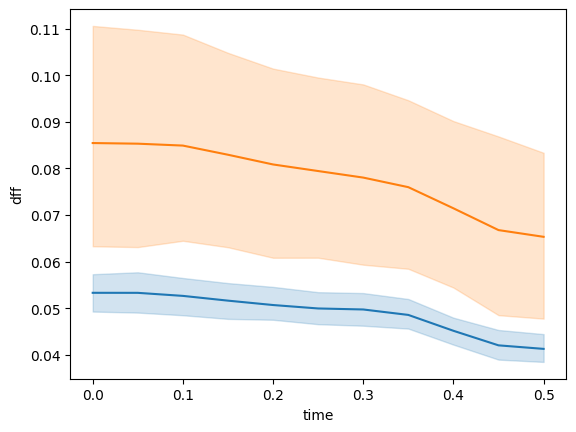

In [ ]:
sns.lineplot(
    data=etr_familiar_global_LM,
    x='time',
    y='dff',
    n_boot=500
)

sns.lineplot(
    data=etr_novel_global_LM,
    x='time',
    y='dff',
    n_boot=500
)


In [ ]:
reshaped_dff = np.reshape(list(etr_familiar_global_LM['dff']),(len(etr_familiar_global_LM[etr_familiar_global_LM['time']==0.4]),-1))

#reshaped_dff = np.reshape(list(etr_novel_global_LM['dff']),(len(etr_novel_global_LM[etr_novel_global_LM['time']==0.4]),-1))
data_484627 = reshaped_dff.mean(axis=0)

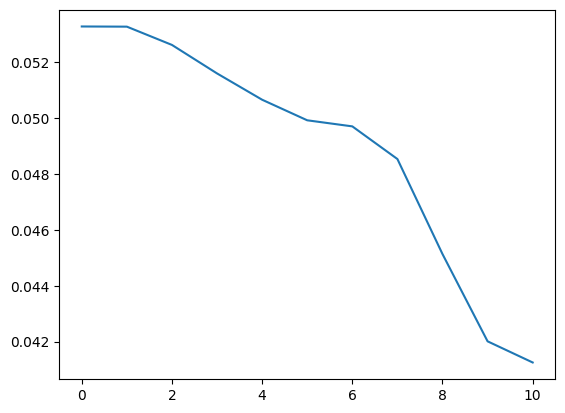

In [ ]:
plt.plot(data_484627)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#path = '/content/drive/MyDrive/Allen_project'

In [ ]:
#np.save('example', curr_exp_id)

In [ ]:
import csv
with open('LM_484627_familiar.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(data_484627)

# before 456915